<a href="https://colab.research.google.com/github/laylamoguibmm/Tasks/blob/main/task7_elevvopaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost lightgbm

In [25]:
# ============================================
# Step 2: Import Libraries
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose


In [26]:
# ============================================
# Step 3: Load and Merge Data
# ============================================
features = pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

print("Data Loaded Successfully!")
print(f"Train shape: {train.shape}, Test shape: {test.shape}, Features shape: {features.shape}, Stores shape: {stores.shape}")

# Merge datasets
train = train.merge(features, on=['Store','Date'], how='left')
train = train.merge(stores, on=['Store'], how='left')

test = test.merge(features, on=['Store','Date'], how='left')
test = test.merge(stores, on=['Store'], how='left')

# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Sort by Store, Dept, Date
train = train.sort_values(by=['Store','Dept','Date'])
test = test.sort_values(by=['Store','Dept','Date'])


Data Loaded Successfully!
Train shape: (421570, 5), Test shape: (115064, 4), Features shape: (8190, 12), Stores shape: (45, 3)


In [27]:
# ============================================
# Step 4: Feature Engineering
# ============================================

# Time-based features
for df in [train, test]:
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['day'] = df['Date'].dt.day

# Lag features
train['Weekly_Sales_Lag1'] = train.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
train['Weekly_Sales_Lag2'] = train.groupby(['Store','Dept'])['Weekly_Sales'].shift(2)

# Rolling averages (BONUS)
train['Weekly_Sales_Roll_Mean'] = train.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(window=4).mean()

# Drop NaNs introduced by lag/rolling
train = train.dropna()


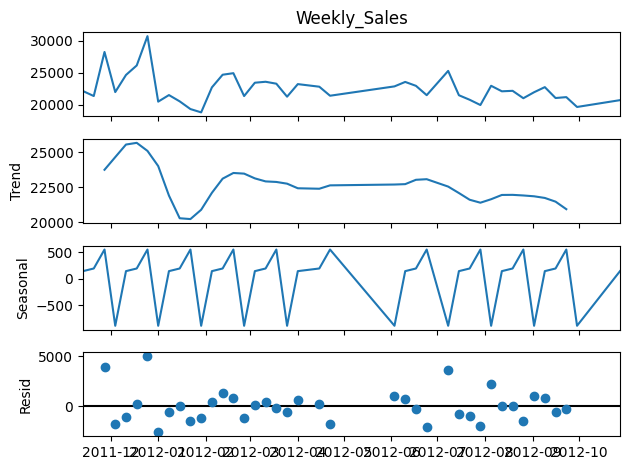

In [33]:
# ============================================
# Step 5: Seasonal Decomposition (BONUS) - FINAL FIX
# ============================================

# Select Weekly_Sales for Store 1 and resample weekly
store_example = (
    train[train['Store'] == 1]
    .set_index('Date')['Weekly_Sales']  # Only the target column
    .resample('W')
    .mean()
    .dropna()  # Remove missing values
)

# Check length and perform decomposition
if store_example.shape[0] >= 8:  # At least 2 cycles for period=4
    decomposition = seasonal_decompose(store_example, model='additive', period=4)
    decomposition.plot()
    plt.show()
else:
    print(f"Not enough data for seasonal decomposition (requires {2*4} observations, got {store_example.shape[0]}).")


In [34]:
# ============================================
# Step 6: Prepare Data for Modeling
# ============================================
features_cols = ['Temperature','Fuel_Price','CPI','Unemployment','year','month','week','day',
                 'Weekly_Sales_Lag1','Weekly_Sales_Lag2','Weekly_Sales_Roll_Mean','Size']
X = train[features_cols]
y = train['Weekly_Sales']

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)


In [35]:
# ============================================
# Step 7: Linear Regression Model
# ============================================
lr_rmse_scores = []
lr = LinearRegression()

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    lr_rmse_scores.append(rmse)

print(f"Linear Regression RMSE per fold: {lr_rmse_scores}")
print(f"Average Linear Regression RMSE: {np.mean(lr_rmse_scores):.2f}")


Linear Regression RMSE per fold: [np.float64(9081.607586330052), np.float64(8079.546381227098), np.float64(7206.84460492591), np.float64(7250.406219736696), np.float64(6508.845445842578)]
Average Linear Regression RMSE: 7625.45


XGBoost RMSE per fold: [np.float64(7530.2523569741315), np.float64(6940.547072849145), np.float64(5424.494824012074), np.float64(6085.948303083562), np.float64(4790.627231213216)]
Average XGBoost RMSE: 6154.37


<Figure size 1000x600 with 0 Axes>

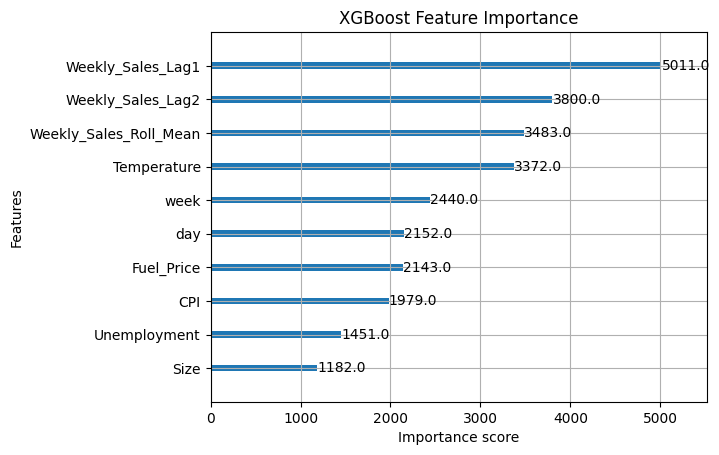

In [36]:
# ============================================
# Step 8: XGBoost Model (BONUS)
# ============================================
xgb_rmse_scores = []
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    xgb_rmse_scores.append(rmse)

print(f"XGBoost RMSE per fold: {xgb_rmse_scores}")
print(f"Average XGBoost RMSE: {np.mean(xgb_rmse_scores):.2f}")

# Feature importance plot
plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()


In [37]:
# ============================================
# Step 9: LightGBM Model (BONUS)
# ============================================
lgb_rmse_scores = []
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=-1, random_state=42)

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    lgb_rmse_scores.append(rmse)

print(f"LightGBM RMSE per fold: {lgb_rmse_scores}")
print(f"Average LightGBM RMSE: {np.mean(lgb_rmse_scores):.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 16155, number of used features: 12
[LightGBM] [Info] Start training from score 20718.275491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 32305, number of used features: 12
[LightGBM] [Info] Start training from score 19001.964477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

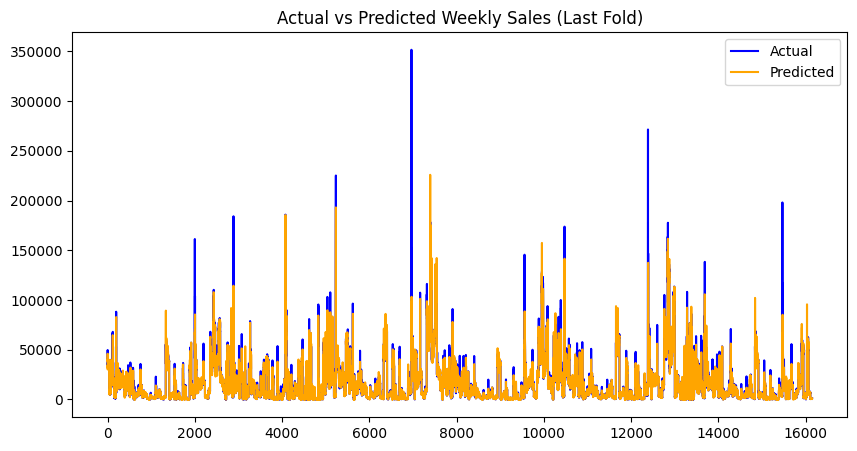

In [38]:
# ============================================
# Step 10: Plot Actual vs Predicted for last validation fold
# ============================================
y_val_plot = y_val.reset_index(drop=True)
y_pred_plot = pd.Series(y_pred)
plt.figure(figsize=(10,5))
plt.plot(y_val_plot, label='Actual', color='blue')
plt.plot(y_pred_plot, label='Predicted', color='orange')
plt.title('Actual vs Predicted Weekly Sales (Last Fold)')
plt.legend()
plt.show()


In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

# ============================================
# Step 11: Retrain XGBoost with all features + seasonal decomposition
# ============================================

# 1. Define all original features to include
feature_cols_to_include = ['Temperature','Fuel_Price','CPI','Unemployment',
                           'year','month','week','day','Size']

# 2. Combine train and test for feature engineering
combined = pd.concat([train[['Store','Dept','Date','Weekly_Sales'] + feature_cols_to_include],
                      test[['Store','Dept','Date'] + feature_cols_to_include]],
                     axis=0, ignore_index=True)

combined = combined.sort_values(by=['Store','Dept','Date'])

# 3. Create lag features and rolling mean
combined['Weekly_Sales_Lag1'] = combined.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
combined['Weekly_Sales_Lag2'] = combined.groupby(['Store','Dept'])['Weekly_Sales'].shift(2)
combined['Weekly_Sales_Roll_Mean'] = combined.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(3).mean()

# 4. Fill NaNs in lag features with 0
combined[['Weekly_Sales_Lag1','Weekly_Sales_Lag2','Weekly_Sales_Roll_Mean']] = \
combined[['Weekly_Sales_Lag1','Weekly_Sales_Lag2','Weekly_Sales_Roll_Mean']].fillna(0)

# 5. Add seasonal decomposition safely
def add_seasonal(group):
    group = group.copy()
    if len(group) >= 104:  # Require 2 full cycles (2 years)
        decomposed = seasonal_decompose(group['Weekly_Sales'].fillna(0),
                                        model='additive', period=52,
                                        extrapolate_trend='freq')
        group['Weekly_Sales_Seasonal'] = decomposed.seasonal
    else:
        group['Weekly_Sales_Seasonal'] = 0
    return group

combined = combined.groupby(['Store','Dept'], group_keys=False).apply(add_seasonal)

# 6. Split back train and test
train_features = combined[combined['Date'].isin(train['Date'])].reset_index(drop=True)
test_features = combined[combined['Date'].isin(test['Date'])].reset_index(drop=True)

# 7. Define final feature list including seasonal
features_cols_final = feature_cols_to_include + ['Weekly_Sales_Lag1','Weekly_Sales_Lag2','Weekly_Sales_Roll_Mean','Weekly_Sales_Seasonal']

X_train = train_features[features_cols_final]
y_train = train_features['Weekly_Sales']

X_test = test_features[features_cols_final]

# 8. Retrain XGBoost with seasonal feature
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)
xgb.fit(X_train, y_train)

# 9. Predict on test set
test['Predicted_Weekly_Sales'] = xgb.predict(X_test)

# 10. Save submission
submission = test[['Store','Dept','Date','Predicted_Weekly_Sales']]
submission.to_csv('walmart_sales_forecast.csv', index=False)
print("✅ Submission file saved: walmart_sales_forecast.csv with seasonal decomposition")


/tmp/ipython-input-2418156507.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined = combined.groupby(['Store','Dept'], group_keys=False).apply(add_seasonal)


✅ Submission file saved: walmart_sales_forecast.csv with seasonal decomposition
